In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import json
import logging
import sys
import ipytest
from pathlib import Path

CODE_FOLDER = Path("code")
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

# Creating Configuration

In [2]:
import os
import sagemaker
from sagemaker.workflow.pipeline_context import (
    LocalPipelineSession,
    PipelineSession,
    Session,
)
from typing import TypedDict
import os

BUCKET = os.environ["BUCKET"]
ROLE = os.environ["ROLE"]


class SessionConfig(TypedDict):
    session: Session
    instance_type: str
    image: str | None
    framework_version: str
    py_version: str


class CometConfig(TypedDict):
    api_key: str | None
    project_name: str | None


class ConfigDict(TypedDict):
    bucket: str
    session_config: SessionConfig
    comet_config: CometConfig


class Configuration:
    def __init__(
        self,
        bucket: str,
        is_local: bool = True,
        instance_type: str = "ml.m5.xlarge",
        image: str = "sagemaker-tensorflow-toolkit-local",
    ) -> None:
        self._bucket = bucket
        self._is_local = is_local
        self.instance_type = instance_type
        self.image = image

    @property
    def bucket(self):
        return self._bucket

    @property
    def is_local(self):
        return self._is_local

    @is_local.setter
    def is_local(self, val):
        if not isinstance(val, bool):
            raise TypeError("Value of is_local should be bool.")
        self._is_local = val

    def load(self) -> ConfigDict:
        return {
            "bucket": self.bucket,
            "session_config": {
                "session": (
                    LocalPipelineSession(default_bucket=os.environ["BUCKET"])
                    if self.is_local
                    else PipelineSession(default_bucket=os.environ["BUCKET"])
                ),
                "instance_type": self.instance_type,
                "image": self.image if self.is_local else None,
                "framework_version": "2.12",
                "py_version": "py310",
            },
            "comet_config": {
                "api_key": os.environ.get("COMET_API_KEY", None),
                "project_name": os.environ.get("COMET_PROJECT_NAME", None),
            },
        }

LOCAL_MODE = False
config = Configuration(bucket=os.environ["BUCKET"], is_local=LOCAL_MODE).load()

In [3]:
import boto3

S3_LOCATION = f"s3://{config['bucket']}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

# Session 2: Exploratory Data Analysis

In [4]:
import polars as pl

In [5]:
import numpy as np
import pandas as pd

penguins = pl.read_csv(
    DATA_FILEPATH,
    dtypes={
        "species": pl.Utf8,
        "island": pl.Utf8,
        "culmen_length_mm": pl.Float32,
        "flipper_length_mm": pl.Float32,
        "body_mass_g": pl.Float32,
        "sex": pl.Utf8,
    },
    null_values=["NA"],
)

In [6]:
penguins.describe()

statistic,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,str,f64,f64,f64,f64,str
"""count""","""344""","""344""",342.0,342.0,342.0,342.0,"""334"""
"""null_count""","""0""","""0""",2.0,2.0,2.0,2.0,"""10"""
"""mean""",null,null,43.921928,17.15117,200.915207,4201.754395,null
"""std""",null,null,5.459584,1.974793,14.061713,801.954529,null
"""min""","""Adelie""","""Biscoe""",32.099998,13.1,172.0,2700.0,"""."""
"""25%""",null,null,39.200001,15.6,190.0,3550.0,null
"""50%""",null,null,44.5,17.3,197.0,4050.0,null
"""75%""",null,null,48.5,18.7,213.0,4750.0,null
"""max""","""Gentoo""","""Torgersen""",59.599998,21.5,231.0,6300.0,"""MALE"""


In [7]:
species_dist = penguins.group_by(pl.col("species"), maintain_order=True).agg(pl.len())
island_dist = penguins.group_by(pl.col("island"), maintain_order=True).agg(pl.len())
sex_dist = penguins.group_by(pl.col("sex"), maintain_order=True).agg(pl.len())

print(species_dist, end="\n\n")
print(island_dist, end="\n\n")
print(sex_dist)

shape: (3, 2)
┌───────────┬─────┐
│ species   ┆ len │
│ ---       ┆ --- │
│ str       ┆ u32 │
╞═══════════╪═════╡
│ Adelie    ┆ 152 │
│ Chinstrap ┆ 68  │
│ Gentoo    ┆ 124 │
└───────────┴─────┘

shape: (3, 2)
┌───────────┬─────┐
│ island    ┆ len │
│ ---       ┆ --- │
│ str       ┆ u32 │
╞═══════════╪═════╡
│ Torgersen ┆ 52  │
│ Biscoe    ┆ 168 │
│ Dream     ┆ 124 │
└───────────┴─────┘

shape: (4, 2)
┌────────┬─────┐
│ sex    ┆ len │
│ ---    ┆ --- │
│ str    ┆ u32 │
╞════════╪═════╡
│ MALE   ┆ 168 │
│ FEMALE ┆ 165 │
│ null   ┆ 10  │
│ .      ┆ 1   │
└────────┴─────┘


In [8]:
penguins = penguins.with_columns(sex=pl.col("sex").replace(".", None))

penguins.select(pl.col("sex").value_counts())

sex
struct[2]
"{""FEMALE"",165}"
"{""MALE"",168}"
"{null,11}"


In [9]:
penguins.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,2,2,2,2,11


In [10]:
# Simple imputer: most frequent value
penguins = penguins.with_columns(pl.all().fill_null(pl.all().mode()))

In [11]:
penguins.null_count()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0


## Computing Robust Z-Score

In [12]:
def compute_robust_zscore(df: pl.DataFrame, col: str) -> pl.Series:
    med_abs_dev = df.select((pl.col(col) - pl.col(col).median()).abs()).median()
    k = 0.6745
    robust_z = df.select(
        (k * (pl.col(col) - pl.col(col).median()) / med_abs_dev).alias(
            f"robust_z_{col}"
        )
    ).to_series()

    return robust_z


culm_length_zscore = compute_robust_zscore(penguins, "culmen_length_mm")
culm_length_zscore

robust_z_culmen_length_mm
f32
-0.747027
-0.689005
-0.572962
-0.456919
-1.095155
…
-0.456919
0.369887
0.892081


In [13]:
for col in penguins.select(pl.col(pl.NUMERIC_DTYPES)).columns:
    robust_zscore = compute_robust_zscore(penguins, col)
    print(robust_zscore.filter(robust_zscore.abs() > 3))

shape: (0,)
Series: 'robust_z_culmen_length_mm' [f32]
[
]
shape: (0,)
Series: 'robust_z_culmen_depth_mm' [f64]
[
]
shape: (0,)
Series: 'robust_z_flipper_length_mm' [f32]
[
]
shape: (0,)
Series: 'robust_z_body_mass_g' [f32]
[
]


## Exploring Predictive Power

Using chi-square test, species does not appear to have an association with sex.

In [14]:
from scipy.stats import chi2_contingency

penguins_pd = penguins.to_pandas()
_, pvalue, *_ = chi2_contingency(pd.crosstab(penguins_pd["sex"], penguins_pd["species"]))
pvalue

0.9123297194631974

However, species appears to be associated with island.

In [15]:
_, pvalue, *_ = chi2_contingency(pd.crosstab(penguins_pd["species"], penguins_pd["island"]))
pvalue

1.3545738297192517e-63

## Visualizing the Data

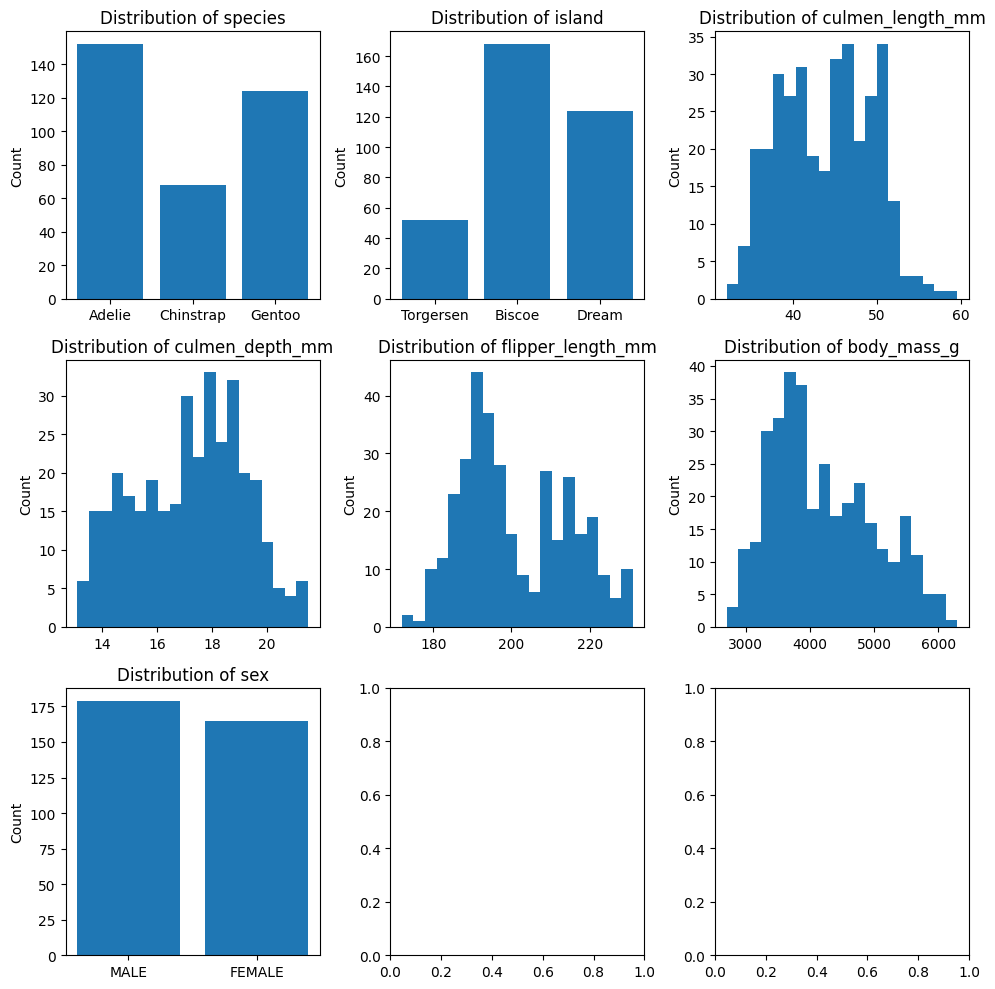

In [16]:
import matplotlib.pyplot as plt


def plot_dist_polars(df: pl.DataFrame, cols: list[str]) -> None:
    nrows = len(cols) // 2
    ncols = 2 + len(cols) % 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))
    axs = axs.flatten()

    for i, col in enumerate(cols):
        if df.schema[col] in pl.NUMERIC_DTYPES:
            values = df.select(pl.col(col)).to_numpy().flatten()
            axs[i].hist(values, bins=20)
        else:
            dist = df.group_by(pl.col(col), maintain_order=True).agg(pl.len())
            cats = dist.select(pl.col(col)).to_numpy().flatten()
            values = dist.select(pl.col("len")).to_numpy().flatten()
            axs[i].bar(cats, values)
        axs[i].set_ylabel("Count")
        axs[i].set_title(f"Distribution of {col}")
        fig.tight_layout()


plot_dist_polars(penguins, penguins.columns)

# Preprocessing Step

In [17]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])

In [18]:
%%writefile {CODE_FOLDER}/processing/script.py

import os
import tarfile
import tempfile
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_dir: str):
    df = _read_data_from_input_csv_files(base_dir)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])]
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            # We exclude the 'sex' feature since we previously
            # determined that it does not have predictive power
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    # Split the data prior to transforms to avoid data leakage
    df_train, df_test = _split_data(df)

    _save_train_baseline(base_dir, df_train)
    _save_test_baseline(base_dir, df_test)

    # Only fit target transformer to train set
    y_train = target_transformer.fit_transform(
        np.array(df_train["species"].values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test["species"].values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    # Only fit features transformer to train set
    X_train = features_transformer.fit_transform(df_train)
    X_test = features_transformer.transform(df_test)

    _save_splits(
        base_dir,
        X_train,
        y_train,
        X_test,
        y_test,
    )
    _save_model(base_dir, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_dir: str) -> pd.DataFrame:
    """Read the data from the input CSV files.

    This function reads every CSV file available and concatenates 
    them into a single dataframe.
    """
    input_dir = Path(base_dir) / "input"
    files = list(input_dir.glob("*.csv"))

    if len(files) == 0:
        message = f"There are no CSV files in {input_dir.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split the data into train and test. Cross-validation will be used."""
    train, test = train_test_split(df, test_size=0.2, stratify=df["species"])

    return train, test


def _save_train_baseline(base_dir: str, df_train: pd.DataFrame) -> None:
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives when deployed.
    """
    baseline_path = Path(base_dir) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_dir: str, df_test: pd.DataFrame):
    """Save the untransformed test data to disk.
    
    We will need the test data to compute a baseline to determine the quality
    of the model predictions when deployed.
    """
    baseline_path = Path(base_dir) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    df.to_csv(baseline_path / "test-baseline.csv", header=True, index=False)


def _save_splits(base_dir, X_train, y_train, X_test, y_test):
    """Save data splits to disk.

    This function concatenates the transformed features and the target variable,
    and saves each one of the split sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_dir) / "train"
    test_path = Path(base_dir) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_dir, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.
    
    This function creates a model.tar.gz file that contains the two
    transformation pipelines we built to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_dir) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(Path(directory) / "features.joblib", arcname="features.joblib")


if __name__ == "__main__":
    preprocess(base_dir="/opt/ml/processing")

Overwriting code/processing/script.py


## Testing the Preprocessing Script

In [19]:
%%ipytest -s

import os
import shutil
import tempfile
import tarfile

import pytest
from processing.script import preprocess


@pytest.fixture(autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)
    preprocess(base_dir=directory)

    yield directory

    shutil.rmtree(directory)


def test_preprocess_generates_data_splits(directory):
    output_directories = os.listdir(directory)

    assert "train" in output_directories
    assert "test" in output_directories


def test_preprocess_generates_baselines(directory):
    output_directories = os.listdir(directory)

    assert "train-baseline" in output_directories
    assert "test-baseline" in output_directories


def test_preprocess_creates_two_models(directory):
    model_path = directory / "model"
    tar = tarfile.open(model_path / "model.tar.gz", "r:gz")

    assert "features.joblib" in tar.getnames()
    assert "target.joblib" in tar.getnames()


def test_splits_are_transformed(directory):
    train = pd.read_csv(directory / "train" / "train.csv", header=None)
    test = pd.read_csv(directory / "test" / "test.csv", header=None)

    number_of_features = 7

    assert train.shape[1] == number_of_features + 1
    assert test.shape[1] == number_of_features + 1


def test_train_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "train-baseline" / "train-baseline.csv",
        header=None,
    )

    island = baseline.iloc[:, 0].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_test_baseline_is_not_transformed(directory):
    baseline = pd.read_csv(
        directory / "test-baseline" / "test-baseline.csv", header=None
    )

    island = baseline.iloc[:, 1].unique()

    assert "Biscoe" in island
    assert "Torgersen" in island
    assert "Dream" in island


def test_train_baseline_includes_header(directory):
    baseline = pd.read_csv(directory / "train-baseline" / "train-baseline.csv")
    assert baseline.columns[0] == "island"


def test_test_baseline_does_not_include_header(directory):
    baseline = pd.read_csv(directory / "test-baseline" / "test-baseline.csv")
    assert baseline.columns[0] != "island"

........
8 passed in 0.13s


In [20]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

In [21]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data"
)

In [22]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    instance_type=config["session_config"]["instance_type"],
    instance_count=1,
    role=ROLE,
    sagemaker_session=config["session_config"]["session"]
)

In [23]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

# The processor will not run immediately as it is configured within a pipeline session
preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            )
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [24]:
from sagemaker.workflow.pipeline import Pipeline

preprocess_pipeline = Pipeline(
    name="preprocess-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

preprocess_pipeline.upsert(role_arn=ROLE)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/preprocess-pipeline',
 'ResponseMetadata': {'RequestId': '92fe7d11-9118-46c2-8687-6d358a1cdaf1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '92fe7d11-9118-46c2-8687-6d358a1cdaf1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '87',
   'date': 'Wed, 22 May 2024 19:51:00 GMT'},
  'RetryAttempts': 0}}

In [25]:
%%script false --no-raise-error

preprocess_pipeline.start()

# Training the Model

In [26]:
(CODE_FOLDER / "training").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/training"])

In [27]:
%%writefile {CODE_FOLDER}/training/script.py

import argparse
import json
import os
import tarfile

from pathlib import Path
from comet_ml import Experiment

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import keras
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from packaging import version
from sklearn.metrics import accuracy_score


def train(
    model_dir: Path | str,
    train_path: Path | str,
    pipeline_path: Path | str,
    experiment: Experiment,
    epochs: int,
    batch_size: int,
    k: int,
    learning_rate: float,
):
    print(f"Keras version: {keras.__version__}")

    X = pd.read_csv(Path(train_path) / "train.csv")
    y = X[X.columns[-1]]
    X = X.drop(X.columns[-1], axis=1)

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []

    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = _create_model(X.shape[1], learning_rate=learning_rate)
        model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
        )

        scores = model.evaluate(X_val, y_val, verbose=0)
        experiment.log_metric(f"fold_{i}_accuracy", scores[1])
        print(f"fold_{i}_accuracy: {scores[1]}")
        cv_scores.append(scores[1])

    cv_val_accuracy = np.mean(cv_scores)
    print(f"cv_val_accuracy: {cv_val_accuracy}")

    # Retrain on full data
    model = _create_model(X.shape[1], learning_rate=learning_rate)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

    model_filepath = (
        Path(model_dir) / "001"
        if version.parse(keras.__version__) < version.parse("3")
        else Path(model_dir) / "penguins.keras"
    )

    model.save(model_filepath)

    with tarfile.open(Path(pipeline_path) / "model.tar.gz", "r:gz") as tar:
        tar.extractall(model_dir)

    if experiment:
        experiment.log_parameters(
            {
                "epochs": epochs,
                "batch_size": batch_size,
                "learning_rate": model.optimizer.learning_rate.numpy(),
            }
        )
        experiment.log_dataset_hash(X)
        experiment.log_metric("cv_val_accuracy", cv_val_accuracy)
        experiment.log_model("penguins", model_filepath.as_posix())


def _create_model(n_input: int, learning_rate: float):
    model = Sequential(
        [
            Input(shape=(n_input,)),
            Dense(10, activation="relu"),
            Dense(8, activation="relu"),
            Dense(3, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=SGD(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int)
    parser.add_argument("--batch_size", type=int)
    parser.add_argument("-k", type=int)
    parser.add_argument("--learning_rate", type=float)
    args, _ = parser.parse_known_args()

    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=False,
            auto_param_logging=False,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    train_env = json.loads(os.environ.get("SM_TRAINING_ENV", {}))
    job_name = train_env.get("job_name", None) if train_env else None

    if job_name and experiment:
        experiment.set_name(job_name)

    train(
        model_dir=os.environ["SM_MODEL_DIR"],
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        pipeline_path=os.environ["SM_CHANNEL_PIPELINE"],
        experiment=experiment,
        epochs=args.epochs,
        batch_size=args.batch_size,
        k=args.k,
        learning_rate=args.learning_rate,
    )

Overwriting code/training/script.py


In [28]:
%%script false --no-raise-error
%%ipytest -s

import os
import shutil
import pytest
import tempfile

from processing.script import preprocess
from training.script import train

@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_directory = Path(directory) / "input"
    input_directory.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_directory / "data.csv")

    directory = Path(directory)

    preprocess(base_dir=directory)
    train(model_dir=directory / "model", train_path=directory / "train", pipeline_path=directory / "model", experiment=None, epochs=1, batch_size=32, k=5, learning_rate=0.01)

    yield directory

    shutil.rmtree(directory)

def test_train_bundles_model_assets(directory):
    bundle = os.listdir(directory / "model")
    assert "penguins.keras" in bundle


def test_train_bundles_transformation_pipelines(directory):
    bundle = os.listdir(directory / "model")
    assert "target.joblib" in bundle
    assert "features.joblib" in bundle

In [29]:
%%writefile {CODE_FOLDER}/training/requirements.txt

comet_ml

Overwriting code/training/requirements.txt


In [30]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat

# Create a parameter for epochs so it can be dynamic and managed by the pipeline
epochs = ParameterInteger(name="epochs", default_value=50)
learning_rate = ParameterFloat(name="learning_rate", default_value=0.01)

estimator = TensorFlow(
    base_job_name="training",
    entry_point="script.py",
    source_dir=f"{(CODE_FOLDER / 'training').as_posix()}",
    # Hyperparameter args are passed to the training script
    # as command-line args
    hyperparameters={ 
        "epochs": epochs,
        "batch_size": 32,
        "k": 5,
        "learning_rate": learning_rate
    },
    environment={
        "COMET_API_KEY": config["comet_config"]["api_key"],
        "COMET_PROJECT_NAME": config["comet_config"]["project_name"],
    },
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9]\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9]\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=config["session_config"]["image"],
    framework_version=config["session_config"]["framework_version"],
    py_version=config["session_config"]["py_version"],
    instance_type=config["session_config"]["instance_type"],
    instance_count=1,
    disable_profiler=True,
    debugger_hook_config=False,
    sagemaker_session=config["session_config"]["session"],
    role=ROLE,
)

In [31]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


def create_training_step(estimator):
    return TrainingStep(
        name="train-model",
        step_args=estimator.fit(
            inputs={
                "train": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "train"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
                ),
                "pipeline": TrainingInput(
                    s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                        "model"
                    ].S3Output.S3Uri,
                    content_type="application/tar+gzip",
                ),
            }
        ),
        # cache_config=cache_config,
    )


train_model_step = create_training_step(estimator)

/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [32]:
train_pipeline = Pipeline(
    name="train-pipeline",
    parameters=[dataset_location, epochs, learning_rate],
    steps=[
        preprocessing_step,
        train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"]
)

train_pipeline.upsert(role_arn=ROLE)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/train-pipeline',
 'ResponseMetadata': {'RequestId': '408b7139-d40b-45e8-af2b-ee9a8783e9e5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '408b7139-d40b-45e8-af2b-ee9a8783e9e5',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '82',
   'date': 'Wed, 22 May 2024 19:51:02 GMT'},
  'RetryAttempts': 2}}

# Creating Custom Training Container

In [33]:
import shutil

(CODE_FOLDER / "containers" / "training").mkdir(parents=True, exist_ok=True)
shutil.copy2(
    CODE_FOLDER / "training" / "script.py",
    CODE_FOLDER / "containers" / "training" / "train.py",
)

PosixPath('code/containers/training/train.py')

In [34]:
%%writefile {CODE_FOLDER}/containers/training/requirements.txt

sagemaker-training
packaging
keras
pandas
scikit-learn
comet_ml
jax[cpu]

Overwriting code/containers/training/requirements.txt


## Building Custom Docker Image

In [35]:
%%writefile {CODE_FOLDER}/containers/training/Dockerfile

FROM python:3.10-slim

RUN apt-get -y update && apt-get install -y --no-install-recommends \
    python3 \
    build-essential \
    libssl-dev \
    pkg-config \
    libhdf5-serial-dev
    

COPY requirements.txt .
RUN pip install --user --upgrade pip
RUN pip3 install -r requirements.txt

COPY train.py /opt/ml/code/train.py
ENV SAGEMAKER_PROGRAM train.py

ENV KERAS_BACKEND=jax

Overwriting code/containers/training/Dockerfile


In [36]:
IMAGE_NAME = "keras-custom-training-container"

if not LOCAL_MODE:
    print("Building Docker image for linux/amd64 architecture...")
    
    !docker build --platform="linux/amd64" -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/
else:
    print("Building Docker image for arm64 architecture...")

    !docker build -t $IMAGE_NAME \
        $CODE_FOLDER/containers/training/

Building Docker image for linux/amd64 architecture...
[+] Building 0.0s (0/0)  docker:desktop-linux
[+] Building 0.0s (0/1)                                    docker:desktop-linux
[+] Building 0.2s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 517B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.2s
[+] Building 0.3s (1/2)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 517B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.3s
[+] Building 0.4s (2/3)                                    docker:desktop-linux
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring 

## Pushing Docker Image to ECR

In [37]:
%%bash -s "$LOCAL_MODE" "$IMAGE_NAME"

algorithm_name=$2
account=$(aws sts get-caller-identity --query Account --output text)

region=$(aws configure get region)
region=${region:-us-east-1}

repository="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

if [ $1 = "False" ]
then
    echo "Pushing to ECR..."
    # Check for repositories with the name and discard output and error to /dev/null
    aws ecr describe-repositories \
        --repository-names "${algorithm_name}" > /dev/null 2>&1
    # Create repository if it doesn't exist based on prev commmand
    if [ $? -ne 0 ]
    then
        aws ecr create-repository \
            --repository-name "${algorithm_name}" > /dev/null
    fi

    aws ecr get-login-password \
        --region ${region}|docker \
        login --username AWS --password-stdin ${repository}

    docker tag ${algorithm_name} ${repository}
    docker push ${repository}
fi

Pushing to ECR...
Login Succeeded
The push refers to repository [217145131661.dkr.ecr.us-east-1.amazonaws.com/keras-custom-training-container]
4037a8fb642b: Preparing
47e91e2460fe: Preparing
4f37b25b4289: Preparing
9c9c162a9dae: Preparing
680cfe5faf4a: Preparing
6020d42d2f73: Preparing
085963967517: Preparing
a2d5e7388727: Preparing
146826fa3ca0: Preparing
5d4427064ecc: Preparing
6020d42d2f73: Waiting
085963967517: Waiting
a2d5e7388727: Waiting
146826fa3ca0: Waiting
5d4427064ecc: Waiting
680cfe5faf4a: Layer already exists
4037a8fb642b: Layer already exists
47e91e2460fe: Layer already exists
9c9c162a9dae: Layer already exists
4f37b25b4289: Layer already exists
6020d42d2f73: Layer already exists
a2d5e7388727: Layer already exists
085963967517: Layer already exists
5d4427064ecc: Layer already exists
146826fa3ca0: Layer already exists
latest: digest: sha256:4bf7191016c03977a0081ddbde77a649dffd1a3b5f8bc17ab1e353a72ade6819 size: 2422


In [38]:
account_id = boto3.client("sts").get_caller_identity().get("Account")
tag = ":latest"

uri_suffix = "amazonaws.com"
if region in ["cn-north-1", "cn-northwest-1"]:
    uri_suffix = "amazonaws.com.cn"

training_container_image = (
    IMAGE_NAME
    if LOCAL_MODE
    else f"{account_id}.dkr.ecr.{region}.amazonaws.com/{IMAGE_NAME}{tag}"
)

training_container_image

'217145131661.dkr.ecr.us-east-1.amazonaws.com/keras-custom-training-container:latest'

In [39]:
from sagemaker.estimator import Estimator

keras_estimator = Estimator(
    base_job_name="custom-training",
    hyperparameters={
        "epochs": epochs,
        "batch_size": 32,
        "k": 5,
        "learning_rate": learning_rate,
    },
    environment={
        "COMET_API_KEY": config["comet_config"]["api_key"],
        "COMET_PROJECT_NAME": config["comet_config"]["project_name"],
    },
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    image_uri=training_container_image,
    instance_count=1,
    instance_type=config["session_config"]["instance_type"],
    sagemaker_session=config["session_config"]["session"],
    role=ROLE,
)

keras_train_model_step = create_training_step(keras_estimator)

/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [40]:
custom_train_pipeline = Pipeline(
    name="custom-train-pipeline",
    parameters=[dataset_location, learning_rate, epochs],
    steps=[
        preprocessing_step,
        keras_train_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

custom_train_pipeline.upsert(role_arn=ROLE)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/custom-train-pipeline',
 'ResponseMetadata': {'RequestId': '51686bb9-6b53-45a3-b8b3-223acb47eb4b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '51686bb9-6b53-45a3-b8b3-223acb47eb4b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '89',
   'date': 'Wed, 22 May 2024 19:51:10 GMT'},
  'RetryAttempts': 0}}

In [41]:
%%script false --no-raise-error
custom_train_pipeline.start(parameters={
    "epochs": 50,
    "learning_rate": 0.001
})

# Tuning Model

In [42]:
USE_TUNING_STEP = False

In [43]:
from sagemaker.parameter import IntegerParameter
from sagemaker.tuner import HyperparameterTuner
from sagemaker.workflow.steps import TuningStep

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="cv_val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges={
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions=[
        {"Name": "cv_val_accuracy", "Regex": "cv_val_accuracy: ([0-9\\.]+)"},
    ],
    max_jobs=3,
    max_parallel_jobs=3,
)

tune_model_step = TuningStep(
    name="tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv",
            ),
            "pipeline": TrainingInput(
                s3_data=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "model"
                ].S3Output.S3Uri,
                content_type="application/tar+gzip",
            ),
        },
    ),
    cache_config=cache_config,
)

tune_pipeline = Pipeline(
    name="tune-pipeline",
    parameters=[dataset_location, epochs, learning_rate],
    steps=[
        preprocessing_step,
        tune_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

tune_pipeline.upsert(role_arn=ROLE)

/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/tune-pipeline',
 'ResponseMetadata': {'RequestId': '708c2907-3043-4888-a697-27a21662b7e2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '708c2907-3043-4888-a697-27a21662b7e2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '81',
   'date': 'Wed, 22 May 2024 19:51:12 GMT'},
  'RetryAttempts': 0}}

In [44]:
%%script false --no-raise-error
tune_pipeline.start()

# Model Evaluation

In [45]:
(CODE_FOLDER / "evaluation").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/evaluation"])

In [46]:
%%writefile {CODE_FOLDER}/evaluation/script.py

import json
import tarfile
import os
from pathlib import Path

from comet_ml import Experiment

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow import keras


def evaluate(model_path, test_path, output_path, experiment: Experiment=None):
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test = X_test.drop(X_test.columns[-1], axis=1)

    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))

    model = keras.models.load_model(Path(model_path) / "001")

    pred = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, pred)
    print(f"Test Accuracy: {accuracy}")

    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")


    evaluation_report = {
        "metrics": {
            "accuracy": {"value": accuracy},
            "precision": {"value": precision},
            "recall": {"value": recall},
        },
    }

    if experiment:
        experiment.log_dataset_hash(X_test)
        experiment.log_model("penguins", (Path(model_path) / "001").as_posix())
        experiment.log_confusion_matrix(y_test.astype(int), pred.astype(int))

    # Calculate accuracy on each island separately
    for i in range (4, 7):
        island_df = X_test[X_test.iloc[:, i] == 1]
        y_island = y_test.loc[island_df.index]

        island_pred = np.argmax(model.predict(island_df), axis=-1)
        island_accuracy = accuracy_score(y_island, island_pred)
        evaluation_report["metrics"][f"island_{i}"] = {"value": island_accuracy}

        if experiment:
            experiment.log_metric(f"island_{i}", island_accuracy)

    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))


if __name__ == "__main__":

    comet_api_key = os.environ.get("COMET_API_KEY", None)
    comet_project_name = os.environ.get("COMET_PROJECT_NAME", None)

    experiment = (
        Experiment(
            project_name=comet_project_name,
            api_key=comet_api_key,
            auto_metric_logging=False,
            auto_param_logging=False,
            log_code=True,
        )
        if comet_api_key and comet_project_name
        else None
    )

    if experiment:
        experiment.set_name("evaluation")

    evaluate(
        model_path="/opt/ml/processing/model/",
        test_path="/opt/ml/processing/test/",
        output_path="/opt/ml/processing/evaluation/",
        experiment=experiment,
    )

Overwriting code/evaluation/script.py


In [47]:
%%script false --no-raise-error
%%ipytest -s

import os
import shutil
import tarfile
import pytest
import tempfile

from processing.script import preprocess
from training.script import train
from evaluation.script import evaluate


@pytest.fixture(scope="function", autouse=False)
def directory():
    directory = tempfile.mkdtemp()
    input_dir = Path(directory) / "input"
    input_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy2(DATA_FILEPATH, input_dir / "data.csv")

    directory = Path(directory)

    preprocess(base_dir=directory)

    train(
        model_dir=directory / "model",
        train_path=directory / "train",
        pipeline_path=directory / "model",
        experiment=None,
        epochs=1,
        batch_size=32,
        k=5,
        learning_rate=0.01
    )

    with tarfile.open(directory / "model.tar.gz", "w:gz") as tar:
        tar.add(directory / "model" / "penguins.keras", arcname="penguins.keras")

    evaluate(
        model_path=directory,
        test_path=directory / "test",
        output_path=directory / "evaluation",
    )

    yield directory / "evaluation"

    shutil.rmtree(directory)


def test_evaluate_generates_evaluation_report(directory):
    output = os.listdir(directory)
    assert "evaluation.json" in output


def test_evaluation_report_contains_accuracy(directory):
    with open(directory / "evaluation.json", "r") as file:
        report = json.load(file)

    assert "metrics" in report
    assert "accuracy" in report["metrics"]

In [48]:
model_assets = train_model_step.properties.ModelArtifacts.S3ModelArtifacts

if USE_TUNING_STEP:
    model_assets = tune_model_step.get_top_model_s3_uri(
        top_k=0,
        s3_bucket=config["session_config"]["session"].default_bucket(),
    )

## Mapping Output to Property File

In [49]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json",
)

In [50]:
from sagemaker.tensorflow import TensorFlowProcessor

evaluation_processor = TensorFlowProcessor(
    base_job_name="evaluation-processor",
    image_uri=config["session_config"]["image"],
    env={
        "COMET_API_KEY": config["comet_config"]["api_key"],
        "COMET_PROJECT_NAME": config["comet_config"]["project_name"],
    },
    framework_version=config["session_config"]["framework_version"],
    py_version=config["session_config"]["py_version"],
    instance_type=config["session_config"]["instance_type"],
    instance_count=1,
    role=ROLE,
    sagemaker_session=config["session_config"]["session"],
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


In [51]:
%%writefile {CODE_FOLDER}/evaluation/requirements.txt

comet_ml

Overwriting code/evaluation/requirements.txt


In [52]:
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=evaluation_processor.run(
        code="script.py",
        source_dir=f"{(CODE_FOLDER / 'evaluation').as_posix()}",
        inputs=[
            ProcessingInput(
                source=preprocessing_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
            ProcessingInput(
                source=model_assets,
                destination="/opt/ml/processing/model",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="evaluation",
                source="/opt/ml/processing/evaluation",
            ),
        ],
    ),
    property_files=[evaluation_report],
    cache_config=cache_config,
)

/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [53]:
evaluate_pipeline = Pipeline(
    name="evaluation-pipeline",
    parameters=[dataset_location, epochs, learning_rate],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

evaluate_pipeline.upsert(role_arn=ROLE)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/evaluation-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/evaluation-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/evaluation-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/evaluation-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/evaluation-pipeline',
 'ResponseMetadata': {'RequestId': '709558d0-dc62-4333-b9a6-0790d54184ba',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '709558d0-dc62-4333-b9a6-0790d54184ba',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '87',
   'date': 'Wed, 22 May 2024 19:51:14 GMT'},
  'RetryAttempts': 0}}

In [54]:
%%script false --no-raise-error

evaluate_pipeline.start()

# Registering the Model

In [55]:
BASIC_MODEL_PACKAGE_GROUP = "basic-penguins"

from sagemaker.tensorflow.model import TensorFlowModel

tensorflow_model = TensorFlowModel(
    model_data=model_assets,
    framework_version=config["session_config"]["framework_version"],
    sagemaker_session=config["session_config"]["session"],
    role=ROLE,
)

In [56]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.functions import Join

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(
            on="/",
            values=[
                evaluate_model_step.properties.ProcessingOutputConfig.Outputs[
                    "evaluation"
                ].S3Output.S3Uri,
                "evaluation.json",
            ],
        ),
        content_type="application/json",
    )
)

In [57]:
from sagemaker.workflow.model_step import ModelStep

class ApprovalStatus:
    APPROVED = "Approved"
    PENDING = "PendingManualApproval"


def create_registration_step(
    model,
    model_package_group_name,
    approval_status=ApprovalStatus.PENDING,
    content_types=["text/csv"],
    response_types=["application/json"],
    model_metrics=None,
    drift_check_baselines=None,
):
    return ModelStep(
        name="register",
        step_args=model.register(
            model_package_group_name=model_package_group_name,
            approval_status=approval_status,
            model_metrics=model_metrics,
            drift_check_baselines=drift_check_baselines,
            content_types=content_types,
            response_types=response_types,
            inference_instances=[config["session_config"]["instance_type"]],
            transform_instances=[config["session_config"]["instance_type"]],
            framework_version=config["session_config"]["framework_version"],
            domain="MACHINE_LEARNING",
            task="CLASSIFICATION",
            framework="TENSORFLOW",
        ),
    )


register_model_step = create_registration_step(
    tensorflow_model,
    BASIC_MODEL_PACKAGE_GROUP,
    model_metrics=model_metrics,
    approval_status=ApprovalStatus.APPROVED,
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


/Users/yangrchen/Documents/self_learning/ml.school/.venv/lib/python3.10/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


In [58]:
register_pipeline = Pipeline(
    name="register-pipeline",
    parameters=[dataset_location, epochs, learning_rate],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        register_model_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

register_pipeline.upsert(role_arn=ROLE)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/register-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/register-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/register-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/register-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/register-pipeline',
 'ResponseMetadata': {'RequestId': 'a35b88f5-0d5e-4726-9973-82f492b8ec34',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a35b88f5-0d5e-4726-9973-82f492b8ec34',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Wed, 22 May 2024 19:51:15 GMT'},
  'RetryAttempts': 0}}

In [65]:
%%script false --no-raise-error

register_pipeline.start()

# Conditional Registration

In [60]:
from sagemaker.workflow.parameters import ParameterFloat
from sagemaker.workflow.fail_step import FailStep

# Establish an accuracy threshold that the model must pass to be registered
accuracy_threshold = ParameterFloat(name="accuracy_threshold", default_value=0.70)
precision_threshold = ParameterFloat(name="precision_threshold", default_value=0.50)
recall_threshold = ParameterFloat(name="recall_threshold", default_value=0.50)

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ",
        values=[
            "Execution failed because the model's accuracy, recall, or precision was lower than",
            accuracy_threshold,
            recall_threshold,
            precision_threshold,
        ],
    ),
)

In [61]:
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo

# Create a condition to check if the accuracy value in the
# property file is greater than our defined threshold
accuracy_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=accuracy_threshold,
)
precision_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.precision.value",
    ),
    right=precision_threshold,
)
recall_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.recall.value",
    ),
    right=recall_threshold,
)

In [62]:
from urllib.parse import urlparse


def retrieve_latest_accuracy(model_group: str) -> dict[str, dict]:
    s3_client = boto3.client("s3")

    # Find all the models that
    model_packages = sagemaker_client.list_model_packages(
        ModelPackageGroupName=model_group
    )
    latest_evaluation_url = sagemaker_client.describe_model_package(
        ModelPackageName=model_packages["ModelPackageSummaryList"][0]["ModelPackageArn"]
    )["ModelMetrics"]["ModelQuality"]["Statistics"]["S3Uri"]

    parsed_url = urlparse(latest_evaluation_url)
    bucket_name = parsed_url.netloc
    key = parsed_url.path.lstrip("/")

    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    metrics = json.loads(response["Body"].read().decode("UTF-8"))["metrics"]

    return metrics["accuracy"]["value"]


retrieve_latest_accuracy(model_group=BASIC_MODEL_PACKAGE_GROUP)

1.0

In [63]:
from sagemaker.workflow.condition_step import ConditionStep

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[accuracy_condition],
    if_steps=[register_model_step],
    else_steps=[fail_step],
)

conditional_pipeline = Pipeline(
    name="conditional-pipeline",
    parameters=[dataset_location, epochs, learning_rate, accuracy_threshold, precision_threshold, recall_threshold],
    steps=[
        preprocessing_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session_config"]["session"],
)

conditional_pipeline.upsert(role_arn=ROLE)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/conditional-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/conditional-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code/evaluation to s3://yang-ml-school/conditional-pipeline/code/e3e161f806d97d578d62a1094b7046f9/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://yang-ml-school/conditional-pipeline/code/f3b7867d7495763812a03744135acb08/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:217145131661:pipeline/conditional-pipeline',
 'ResponseMetadata': {'RequestId': '852c011e-5ee1-496b-b2fe-f60f7be8748f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '852c011e-5ee1-496b-b2fe-f60f7be8748f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '88',
   'date': 'Wed, 22 May 2024 19:51:17 GMT'},
  'RetryAttempts': 0}}

In [64]:
# %%script false --no-raise-error

conditional_pipeline.start(
    parameters={
        "accuracy_threshold": retrieve_latest_accuracy(model_group=BASIC_MODEL_PACKAGE_GROUP),
    }
)

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:217145131661:pipeline/conditional-pipeline/execution/94iux4j17dqv', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x10c1cba30>)